In [2]:
import numpy as np 
import torch 
import torch.nn as nn 
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [3]:
device= "cuda" if torch.cuda.is_available() else "cpu"

In [4]:
device

'cuda'

In [5]:
import audio 
spectrogram = audio.log_mel_spectrogram(r"F:\works\A-important\A-neurals\New folder\dev-clean\LibriSpeech\dev-clean\84\121123\84-121123-0001.flac") 

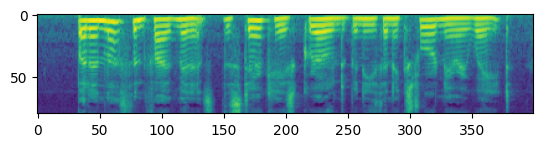

In [6]:
plt.imshow(spectrogram);

In [22]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from dataclasses import dataclass


@dataclass
class Configuration:
    n_encoder_layers: int = 2
    n_decoder_layers: int = 4
    d_model: int = 512
    n_heads: int = 8
    d_ff: int = 2048
    max_seq_length: int = 1500
    vocab_size: int = 51876
    n_conv_channels: list = (80, 256, 512, 1024)
    dropout: float = 0.1


class PositionalEncoding(nn.Module):
    def __init__(self, max_len: int, d_model: int):
        super().__init__()
        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-np.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return x + self.pe[:x.size(0)]


class CustomAttention(nn.Module):
    def __init__(self, d_model: int, n_heads: int, dropout: float = 0.1):
        super().__init__()
        assert d_model % n_heads == 0, "d_model must be divisible by n_heads"
        self.d_model = d_model
        self.n_heads = n_heads
        self.head_dim = d_model // n_heads

        self.query = nn.Linear(d_model, d_model, bias=False)
        self.key = nn.Linear(d_model, d_model, bias=False)
        self.value = nn.Linear(d_model, d_model, bias=False)
        self.out_proj = nn.Linear(d_model, d_model, bias=False)
        self.dropout = nn.Dropout(dropout)

    def scaled_dot_product_attention(self, q, k, v, mask=None):
        attn_scores = torch.matmul(q, k.transpose(-2, -1)) / np.sqrt(self.head_dim)
        if mask is not None:
            attn_scores += mask
        attn_weights = F.softmax(attn_scores, dim=-1)
        return torch.matmul(attn_weights, v)

    def forward(self, q, k, v, mask=None):
        attn_output = self.scaled_dot_product_attention(q, k, v, mask)
        return self.out_proj(attn_output)


class EncoderLayer(nn.Module):
    def __init__(self, config: Configuration):
        super().__init__()
        self.attn = CustomAttention(config.d_model, config.n_heads, config.dropout)
        self.attn_layer_norm = nn.LayerNorm(config.d_model, eps=1e-4)
        self.activation = nn.SiLU()
        self.fc1 = nn.Linear(config.d_model, config.d_ff)
        self.fc2 = nn.Linear(config.d_ff, config.d_model)
        self.ffn_layer_norm = nn.LayerNorm(config.d_model, eps=1e-4)
        self.dropout = nn.Dropout(config.dropout)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        attn_output = self.attn(x, x, x)  # Self-attention
        x = self.attn_layer_norm(x + self.dropout(attn_output))

        # Feed-forward network
        ffn_output = self.fc2(self.dropout(self.activation(self.fc1(x))))
        x = self.ffn_layer_norm(x + ffn_output)
        return x


class DecoderLayer(nn.Module):
    def __init__(self, config: Configuration):
        super().__init__()
        self.self_attn = CustomAttention(config.d_model, config.n_heads, config.dropout)
        self.cross_attn = CustomAttention(config.d_model, config.n_heads, config.dropout)
        self.ffn = nn.Sequential(
            nn.Linear(config.d_model, config.d_ff),
            nn.ReLU(),
            nn.Dropout(config.dropout),
            nn.Linear(config.d_ff, config.d_model),
        )
        self.norm1 = nn.LayerNorm(config.d_model)
        self.norm2 = nn.LayerNorm(config.d_model)
        self.norm3 = nn.LayerNorm(config.d_model)
        self.dropout = nn.Dropout(config.dropout)

    def forward(self, x: torch.Tensor, encoder_output: torch.Tensor, tgt_mask: torch.Tensor = None) -> torch.Tensor:
        # Self-attention
        self_attn_output = self.self_attn(x, x, x, tgt_mask)
        x = self.norm1(x + self.dropout(self_attn_output))

        # Cross-attention
        cross_attn_output = self.cross_attn(x, encoder_output, encoder_output)
        x = self.norm2(x + self.dropout(cross_attn_output))

        # Feed-forward network
        x = self.norm3(x + self.dropout(self.ffn(x)))
        return x


class SONATA_Encoder(nn.Module):
    def __init__(self, config: Configuration):
        super().__init__()
        self.conv1 = nn.Conv1d(config.n_conv_channels[0], config.n_conv_channels[1], 3, 1, 1)
        self.conv2 = nn.Conv1d(config.n_conv_channels[1], config.n_conv_channels[2], 3, 1, 1)
        self.conv3 = nn.Conv1d(config.n_conv_channels[2], config.n_conv_channels[3], 3, 2, 1)
        self.projection = nn.Linear(config.n_conv_channels[3], config.d_model)
        self.pos_embed = PositionalEncoding(config.max_seq_length, config.d_model)
        self.layers = nn.ModuleList([EncoderLayer(config) for _ in range(config.n_encoder_layers)])
        self.layer_norm = nn.LayerNorm(config.d_model, eps=1e-4)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = x.transpose(1, 2)
        x = self.projection(x)
        x = self.pos_embed(x)
        for layer in self.layers:
            x = layer(x)
        return self.layer_norm(x)


class SONATA_Decoder(nn.Module):
    def __init__(self, config: Configuration):
        super().__init__()
        self.embed_tokens = nn.Embedding(config.vocab_size, config.d_model)
        self.pos_embed = PositionalEncoding(config.max_seq_length, config.d_model)
        self.layers = nn.ModuleList([DecoderLayer(config) for _ in range(config.n_decoder_layers)])
        self.layer_norm = nn.LayerNorm(config.d_model, eps=1e-4)

    def forward(self, encoder_output: torch.Tensor, seperation: int, tgt_mask: torch.Tensor = None) -> torch.Tensor:
        # Directly use the encoder output as the input to the decoder
        if seperation:
            x = self.embed_tokens(encoder_output)
            x = self.pos_embed(x)
            for layer in self.layers:
                x = layer(x, encoder_output, tgt_mask)
            return self.layer_norm(x)
        else:
            x = self.pos_embed(encoder_output)
            for layer in self.layers:
                x = layer(x, encoder_output, tgt_mask)
            return self.layer_norm(x)
            


class SONATA(nn.Module):
    def __init__(self, config: Configuration):
        super().__init__()
        self.Encoder = SONATA_Encoder(config)
        self.Decoder = SONATA_Decoder(config)
        self.proj_out = nn.Linear(config.d_model, config.vocab_size)

    def forward(self, src: torch.Tensor, seperation: int, tgt_mask: torch.Tensor = None) -> torch.Tensor:
        encoder_output = self.Encoder(src)
        decoder_output = self.Decoder(encoder_output, seperation, tgt_mask)
        return self.proj_out(decoder_output)


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


# Instantiate the model
config = Configuration()
model = SONATA(config)
device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)

print(f"The model has {count_parameters(model):,} trainable parameters")

# Sample input
src = torch.randn(1, 80, 400).to(device)  # Simulated spectrogram: (batch_size, features, time_steps)
output = model(src=src, seperation = 0)
print(f"Batch Size: {1}, Output Shape: {output.shape}")


The model has 78,829,476 trainable parameters
Batch Size: 1, Output Shape: torch.Size([1, 200, 51876])


In [23]:
spectrogram.reshape(-1, 80, 400).shape

torch.Size([1, 80, 400])

In [24]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from dataclasses import dataclass


@dataclass
class Configuration:
    n_encoder_layers: int = 2
    n_decoder_layers: int = 4
    d_model: int = 512
    n_heads: int = 8
    d_ff: int = 2048
    max_seq_length: int = 1500
    vocab_size: int = 51876
    n_conv_channels: list = (80, 256, 512, 1024)
    dropout: float = 0.1


class PositionalEncoding(nn.Module):
    def __init__(self, max_len: int, d_model: int):
        super().__init__()
        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-np.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return x + self.pe[:x.size(0)]


class CustomAttention(nn.Module):
    def __init__(self, d_model: int, n_heads: int, dropout: float = 0.1):
        super().__init__()
        assert d_model % n_heads == 0, "d_model must be divisible by n_heads"
        self.d_model = d_model
        self.n_heads = n_heads
        self.head_dim = d_model // n_heads

        self.query = nn.Linear(d_model, d_model, bias=False)
        self.key = nn.Linear(d_model, d_model, bias=False)
        self.value = nn.Linear(d_model, d_model, bias=False)
        self.out_proj = nn.Linear(d_model, d_model, bias=False)
        self.dropout = nn.Dropout(dropout)

    def scaled_dot_product_attention(self, q, k, v, mask=None):
        attn_scores = torch.matmul(q, k.transpose(-2, -1)) / np.sqrt(self.head_dim)
        if mask is not None:
            attn_scores += mask
        attn_weights = F.softmax(attn_scores, dim=-1)
        return torch.matmul(attn_weights, v)

    def forward(self, q, k, v, mask=None):
        attn_output = self.scaled_dot_product_attention(q, k, v, mask)
        return self.out_proj(attn_output)


class EncoderLayer(nn.Module):
    def __init__(self, config: Configuration):
        super().__init__()
        self.attn = CustomAttention(config.d_model, config.n_heads, config.dropout)
        self.attn_layer_norm = nn.LayerNorm(config.d_model, eps=1e-4)
        self.activation = nn.SiLU()
        self.fc1 = nn.Linear(config.d_model, config.d_ff)
        self.fc2 = nn.Linear(config.d_ff, config.d_model)
        self.ffn_layer_norm = nn.LayerNorm(config.d_model, eps=1e-4)
        self.dropout = nn.Dropout(config.dropout)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        attn_output = self.attn(x, x, x)  # Self-attention
        x = self.attn_layer_norm(x + self.dropout(attn_output))

        # Feed-forward network
        ffn_output = self.fc2(self.dropout(self.activation(self.fc1(x))))
        x = self.ffn_layer_norm(x + ffn_output)
        return x


class DecoderLayer(nn.Module):
    def __init__(self, config: Configuration):
        super().__init__()
        self.self_attn = CustomAttention(config.d_model, config.n_heads, config.dropout)
        self.cross_attn = CustomAttention(config.d_model, config.n_heads, config.dropout)
        self.ffn = nn.Sequential(
            nn.Linear(config.d_model, config.d_ff),
            nn.ReLU(),
            nn.Dropout(config.dropout),
            nn.Linear(config.d_ff, config.d_model),
        )
        self.norm1 = nn.LayerNorm(config.d_model)
        self.norm2 = nn.LayerNorm(config.d_model)
        self.norm3 = nn.LayerNorm(config.d_model)
        self.dropout = nn.Dropout(config.dropout)

    def forward(self, x: torch.Tensor, encoder_output: torch.Tensor, tgt_mask: torch.Tensor = None) -> torch.Tensor:
        # Self-attention
        self_attn_output = self.self_attn(x, x, x, tgt_mask)
        x = self.norm1(x + self.dropout(self_attn_output))

        # Cross-attention
        cross_attn_output = self.cross_attn(x, encoder_output, encoder_output)
        x = self.norm2(x + self.dropout(cross_attn_output))

        # Feed-forward network
        x = self.norm3(x + self.dropout(self.ffn(x)))
        return x


class SONATA_Encoder(nn.Module):
    def __init__(self, config: Configuration):
        super().__init__()
        self.conv1 = nn.Conv1d(config.n_conv_channels[0], config.n_conv_channels[1], 3, 1, 1)
        self.conv2 = nn.Conv1d(config.n_conv_channels[1], config.n_conv_channels[2], 3, 1, 1)
        self.conv3 = nn.Conv1d(config.n_conv_channels[2], config.n_conv_channels[3], 3, 2, 1)
        self.projection = nn.Linear(config.n_conv_channels[3], config.d_model)
        self.pos_embed = PositionalEncoding(config.max_seq_length, config.d_model)
        self.layers = nn.ModuleList([EncoderLayer(config) for _ in range(config.n_encoder_layers)])
        self.layer_norm = nn.LayerNorm(config.d_model, eps=1e-4)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = x.transpose(1, 2)
        x = self.projection(x)
        x = self.pos_embed(x)
        for layer in self.layers:
            x = layer(x)
        return self.layer_norm(x)


class SONATA_Decoder(nn.Module):
    def __init__(self, config: Configuration):
        super().__init__()
        self.embed_tokens = nn.Embedding(config.vocab_size, config.d_model)
        self.pos_embed = PositionalEncoding(config.max_seq_length, config.d_model)
        self.layers = nn.ModuleList([DecoderLayer(config) for _ in range(config.n_decoder_layers)])
        self.layer_norm = nn.LayerNorm(config.d_model, eps=1e-4)

    def forward(self, encoder_output: torch.Tensor, seperation: int, tgt_mask: torch.Tensor = None) -> torch.Tensor:
        # Directly use the encoder output as the input to the decoder
        if seperation:
            x = self.embed_tokens(encoder_output)
            x = self.pos_embed(x)
            for layer in self.layers:
                x = layer(x, encoder_output, tgt_mask)
            return self.layer_norm(x)
        else:
            x = self.pos_embed(encoder_output)
            for layer in self.layers:
                x = layer(x, encoder_output, tgt_mask)
            return self.layer_norm(x)
            


class SONATA(nn.Module):
    def __init__(self, config: Configuration):
        super().__init__()
        self.Encoder = SONATA_Encoder(config)
        self.Decoder = SONATA_Decoder(config)
        self.proj_out = nn.Linear(config.d_model, config.vocab_size)

    def forward(self, src: torch.Tensor, seperation: int, tgt_mask: torch.Tensor = None) -> torch.Tensor:
        encoder_output = self.Encoder(src)
        decoder_output = self.Decoder(encoder_output, seperation, tgt_mask)
        return self.proj_out(decoder_output)


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


# Instantiate the model
config = Configuration()
model = SONATA(config)
device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)

print(f"The model has {count_parameters(model):,} trainable parameters")

# Sample input
src = torch.randn(1, 80, 400).to(device)  # Simulated spectrogram: (batch_size, features, time_steps)
output = model(src=src, seperation = 0)
print(f"Batch Size: {1}, Output Shape: {output.shape}")


The model has 78,829,476 trainable parameters
Batch Size: 1, Output Shape: torch.Size([1, 200, 51876])


In [31]:
spectrogram= spectrogram.reshape(1, 80, 400).to(device="cuda")
model(spectrogram, 0).shape

torch.Size([1, 200, 51876])

Checking base directory: F:\works\A-important\A-neurals\New folder\dev-clean\LibriSpeech\dev-clean
Storage directory: F:\works\A-important\A-neurals\New folder\data
Base directory exists and contains: ['1272', '1462', '1673', '174', '1919', '1988', '1993', '2035', '2078', '2086', '2277', '2412', '2428', '251', '2803', '2902', '3000', '3081', '3170', '3536', '3576', '3752', '3853', '422', '5338', '5536', '5694', '5895', '6241', '6295', '6313', '6319', '6345', '652', '777', '7850', '7976', '8297', '84', '8842']

Scanning directory structure:

First level folder: 1272
Contains: ['128104', '135031', '141231']
  Subfolder 128104 contains: ['1272-128104-0000.flac', '1272-128104-0001.flac', '1272-128104-0002.flac', '1272-128104-0003.flac', '1272-128104-0004.flac', '1272-128104-0005.flac', '1272-128104-0006.flac', '1272-128104-0007.flac', '1272-128104-0008.flac', '1272-128104-0009.flac', '1272-128104-0010.flac', '1272-128104-0011.flac', '1272-128104-0012.flac', '1272-128104-0013.flac', '1272-1

: 

In [5]:
import json

# Load custom tokenizer mappings (assuming it's in JSON format)
with open(r'F:\works\A-important\A-neurals\SONATA\src\assets\multilang.tiktoken', 'r', encoding='utf-8') as f:
    tokenizer_data = json.load(f)

# Example tokenizer mapping (this depends on how 'multilang.tiktoken' is structured)
tokens = tokenizer_data['tokens']  # This is just an example. Adjust based on the actual structure.
vocab = tokenizer_data['vocab']  # Similarly, adjust this based on the file content.

# Example encoding function based on the custom data
def custom_encode(text):
    return [tokens.get(word, 0) for word in text.split()]

def custom_decode(tokens):
    reverse_vocab = {v: k for k, v in vocab.items()}
    return ' '.join([reverse_vocab.get(token, '') for token in tokens])

# Encoding and decoding using the custom functions
encoded_text = custom_encode("Hello, how are you?")
decoded_text = custom_decode(encoded_text)

print(f"Encoded: {encoded_text}")
print(f"Decoded: {decoded_text}")


JSONDecodeError: Expecting value: line 1 column 1 (char 0)

In [10]:
import tiktoken

# Initialize the tokenizer for GPT-3
enc = tiktoken.get_encoding("gpt2")

# Sample text
text = "I love coding."

# Tokenize the text
tokens = enc.encode(text)

# Print the tokens
print(tokens)


[40, 1842, 19617, 13]


In [18]:
import tiktoken

# Load the GPT-2 tokenizer
tokenizer = tiktoken.get_encoding("gpt2")

# Get the size of the vocabulary by counting the tokens
vocab_size = len(tokenizer._tokenizer.get_vocab())
print("Vocabulary size:", vocab_size)


AttributeError: 'Encoding' object has no attribute '_tokenizer'

In [19]:
tiktoken.get_encoding??

Signature: tiktoken.get_encoding(encoding_name: 'str') -> 'Encoding'
Docstring: <no docstring>
Source:   
def get_encoding(encoding_name: str) -> Encoding:
    if encoding_name in ENCODINGS:
        return ENCODINGS[encoding_name]

    with _lock:
        if encoding_name in ENCODINGS:
            return ENCODINGS[encoding_name]

        if ENCODING_CONSTRUCTORS is None:
            _find_constructors()
            assert ENCODING_CONSTRUCTORS is not None

        if encoding_name not in ENCODING_CONSTRUCTORS:
            raise ValueError(
                f"Unknown encoding {encoding_name}. Plugins found: {_available_plugin_modules()}"
            )

        constructor = ENCODING_CONSTRUCTORS[encoding_name]
        enc = Encoding(**constructor())
        ENCODINGS[encoding_name] = enc
        return enc
File:      c:\users\admin\appdata\local\programs\python\python39\lib\site-packages\tiktoken\registry.py
Type:      function

In [20]:
import tiktoken

# Load the GPT-2 tokenizer
tokenizer = tiktoken.get_encoding("gpt2")

# Get the size of the vocabulary
vocab_size = tokenizer.num_tokens
print("Vocabulary size:", vocab_size)


AttributeError: 'Encoding' object has no attribute 'num_tokens'

In [22]:
tokenizer.max_token_value

50256